In [1]:
# Read simulator images from udacity training set
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

augment_cnt = 4000
sample_cnt = int(os.popen("wc -l data/driving_log.csv | awk '{print $1}'").read().strip())
lines = np.arange(sample_cnt-1+augment_cnt)
np.random.shuffle(lines)

#80/20 split for training and validation sets
train_split=int(len(lines)*0.8)
train_idx=lines[0:train_split]
valid_idx=lines[train_split:len(lines)]


In [2]:
def process_img(image, corr):
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #img = img[..., np.newaxis]
    #img = img[50:300,:]
    if corr == -1 :
        img = np.fliplr(img)
    return img

def get_data(sample_idx, batch_size):
    while 1:
        df = pd.read_csv('data/driving_log.csv')
        idx=0
        images=[]
        measurements = []
        for x in range(batch_size):
            if idx >= sample_cnt:   #flip an image
                idx1 = idx % sample_cnt
                corr = -1
            else :
                idx1 = idx
                corr = 1
                
            cimg = "data/" + df["center"][idx1].strip()
            ang = df["steering"][idx1]
            limg = "data/" + df["left"][idx1].strip()
            rimg = "data/" + df["right"][idx1].strip()
            
            img = cv2.imread(cimg)
            images.append(process_img(img, corr))
            measurements.append(ang*corr)
            
            img = cv2.imread(limg)
            images.append(process_img(img, corr))
            measurements.append((ang+0.25)*corr)
            
            img = cv2.imread(rimg)
            images.append(process_img(img, corr))
            measurements.append((ang-0.25)*corr)
            
            idx+=1
        yield (np.array(images), np.array(measurements))
        

In [3]:
# Model based on https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# Using keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Dense, Lambda, Cropping2D, Activation, Flatten

model = Sequential()

# pre process as described in lecture
# 1. Normalize input data
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3))) 

# 2. Crop 60 pixels off the top and 10 pixels off the bottom of images
model.add(Cropping2D(cropping=((60,10),(0,0)))) 

# Nvidia model layers
model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(filters=36, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
batch_size=60
history = model.fit_generator(get_data(train_idx, batch_size), 
                    steps_per_epoch=len(train_idx) / batch_size,
                    validation_data=get_data(valid_idx, batch_size),
                    validation_steps=len(valid_idx) / batch_size,
                    epochs=10)

model.save('model.nv.h5')

Using TensorFlow backend.


Epoch 1/10
195/194 [==============================] - 95s - loss: 0.0049 - acc: 0.2944 - val_loss: 0.0379 - val_acc: 0.2944

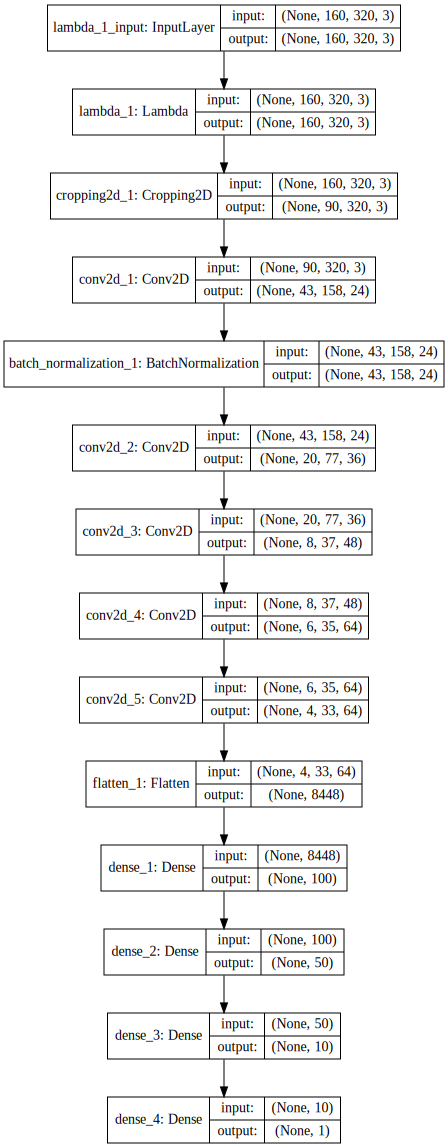

In [4]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

**Behavioral Cloning Project**

Second attempt for a model using python generators. It does use a lot lesser memory but varying the epochs/batch sizes is not giving good results.